<a href="https://colab.research.google.com/github/Nourallaah/FitzHugh-Nagumo-PINN-Simulation/blob/main/Comparison_between_PINN_and_all_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook models and simulates a reaction-diffusion system based on the FitzHugh-Nagumo (FHN) equations. The goal is to compare traditional numerical methods with machine learning-based solvers**


---





1. **What is implemented**


---



*  Euler Finite Difference Method (FDM) – a simple explicit time-stepping scheme.

* Finite Volume Method (FVM) – a conservative spatial discretization method.

* Physics-Informed Neural Network (PINN) – a deep learning model that solves PDEs by minimizing the residual of the governing equations and enforcing initial/boundary conditions.


---



2. This code solves the 1D diffusion-reaction PDE system by The FHN equations which are explained in details in the report:

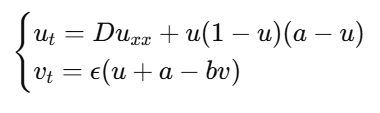


---



3. **Features:**


---



* Supports 5 different boundary condition cases, including:

  1. Analytical Dirichlet

 2. Constant Dirichlet

  3. Analytical Neumann(derivative-based)

 4.  Homogeneous Neumann

 5. No BCs


---
The model handles comparison between The deep learning model, Analytical solution, Numerical methods and computes the following between the PINN and each of the rest: RMSE, MAE. MSE, Accuracy, Precision and computation time


---

Next we will discuss every part of the code




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---------- global parameters ----------
D, a = 1.0, 0.3
xmin, xmax = -20, 20
N_x = 200
dt = 0.002
x_np = np.linspace(xmin, xmax, N_x)
dx = x_np[1] - x_np[0]
ncase = 1  # Change between 1 to 5
t_eval = 0.5
n_steps = int(t_eval / dt)



> The global parameters define the physical and numerical setup of the problem. They specify the diffusion coefficient, advection speed, domain boundaries, spatial and temporal resolution, and the total simulation time. Additionally, a case selector determines which type of boundary condition is applied during the simulation. Together, these parameters control the behavior and accuracy of the model as it evolves over time within the specified domain.





In [ ]:
# ---------- Safe exp ----------
def safe_exp(z):
    return np.exp(np.clip(z, -700, 700))

# ---------- Analytical ----------
def analytical_solution(x, t, D=1.0, a=0.3):
    return 1 / (1 + np.exp(x / np.sqrt(2 * D) + (a - 0.5) * t))

def analytical_solution_derivative(x, t, D=1.0, a=0.3):
    exp_term = safe_exp(x / np.sqrt(2 * D) + (a - 0.5) * t)
    denom = (1 + exp_term) ** 2
    return -exp_term / (np.sqrt(2 * D) * denom)



```
safe_exp(z)
```



**Purpose:**

 Computes the exponential of z while avoiding numerical overflow or underflow.

**How it works:**

Uses `np.clip` to limit the input `z` within the range [-700, 700]. This prevents `np.exp` from producing extremely large or small values that could cause computational errors or warnings.


```
analytical_solution(x, t, D=1.0, a=0.3)

```


**Purpose:**

Returns the analytical solution of the modeled problem at spatial position `x` and time `t`.

 **How it works:**

Computes a logistic-type function involving `x`, `t`, diffusion coefficient `D`, and advection speed `a`.



```
analytical_solution_derivative(x, t, D=1.0, a=0.3)
```

**Purpose:**

Computes the spatial derivative of the analytical solution at position `x` and time `t`.

**How it works:**

Uses the `safe_exp` function to calculate the exponential term safely, Then applies the derivative formula of the logistic function, which involves the exponential term and its squared denominator and finally; returns the gradient of the solution with respect to `x`.

In [ ]:
# ---------- Initial & Boundary Conditions ----------
def ic_smooth():
    return analytical_solution(x_np, 0).flatten()

def apply_bc(u, t, ncase):
    if ncase == 1:
        u[0], u[-1] = analytical_solution(x_np[0], t), analytical_solution(x_np[-1], t)
    elif ncase == 2:
        u[0], u[-1] = 1.0, 0.0
    elif ncase == 3:
        arg0 = x_np[0] / np.sqrt(2 * D) + (a - 0.5) * t
        ux0 = -safe_exp(arg0) / (np.sqrt(2 * D) * (1 + safe_exp(arg0)) ** 2)
        argn = x_np[-1] / np.sqrt(2 * D) + (a - 0.5) * t
        uxn = -safe_exp(argn) / (np.sqrt(2 * D) * (1 + safe_exp(argn)) ** 2)
        u[0] = u[1] - dx * ux0
        u[-1] = u[-2] + dx * uxn
    elif ncase == 4:
        u[0], u[-1] = u[1], u[-2]
    elif ncase == 5:
        u[0], u[-1] = u[0], u[-1]
    return u

```
ic_smooth()
```

*   This function returns the initial condition
`u
(
x
,
0
)` for the entire spatial grid `x_np`.
*  It calls analytical_solution`(x_np, 0)`, which presumably computes the exact or analytical solution of the problem at time zero.

*   `.flatten()` converts the possibly multidimensional output into a 1D array, suitable for numerical methods.
*   This provides a smooth initial profile for
`u` based on the analytical solution.


```
apply_bc(u, t, ncase)
```
**Explanation:**
This function modifies the boundary values of the solution array `u` at the current time `t` based on the chosen boundary condition case `ncase`.
  
**Case 1:**

This is a **Dirichlet boundary condition**, where the solution is fixed to known values at the edges.

*   Sets the boundary values
`u0`

  and
`u(N−1)`
  to the exact analytical solution at the boundaries.

**Case 2: Fixed Dirichlet BC**

This is a simple fixed boundary condition, often used in test problems or to impose known states at boundaries.

*   Sets the left boundary to 1.0 and the right boundary to 0.0.

**Case 3: Neumann boundary conditions**

This case applies Neumann boundary conditions (specifying the derivative of
u at the boundaries).

*  `ux0` and `uxn` are approximations of the spatial derivatives
`∂x/∂u` at the left and right boundaries, respectively.
The boundary values are updated using a first-order finite difference approximation:

Left boundary:

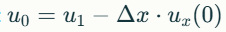

Right boundary:

image.png

*   This enforces the gradient of `u` at boundaries rather than the value.

**Case 4: Neumann BC with Zero Gradient**

*  Sets the boundary values equal to their immediate neighbors inside the domain.

*  This effectively imposes a zero-gradient (homogeneous Neumann) boundary condition:

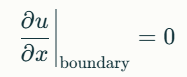

**Case 5: Free of BCs**



---













In [ ]:
# ---------- Euler Method ----------
def euler_fdm_to_t(u0, n_steps, ncase):
    u = u0.copy()
    for n in range(n_steps):
        rhs = D * (u[2:] - 2 * u[1:-1] + u[:-2]) / dx ** 2 - u[1:-1] * (1 - u[1:-1]) * (a - u[1:-1])
        u[1:-1] += dt * rhs
        u = apply_bc(u, (n + 1) * dt, ncase)
    return u
    # ---------- Finite Volume Method ----------
def fvm_to_t(u0, n_steps, ncase):
    u = u0.copy()
    for n in range(n_steps):
        flux = np.zeros_like(u)
        flux[1:-1] = D * (u[2:] - u[:-2]) / (2 * dx)
        div_flux = np.zeros_like(u)
        div_flux[1:-1] = (flux[2:] - flux[:-2]) / (2 * dx)
        reaction = u * (1 - u) * (a - u)
        u[1:-1] += dt * (div_flux[1:-1] - reaction[1:-1])
        u = apply_bc(u, (n + 1) * dt, ncase)
    return u


The functions responsible for executing the numrical methods


---





In [ ]:
# ---------- PINN Model ----------
class FHN_PINN(nn.Module):
    def __init__(self, layers):
        super(FHN_PINN, self).__init__()
        modules = []
        for i in range(len(layers) - 1):
            modules.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                modules.append(nn.Tanh())
        self.net = nn.Sequential(*modules)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

The provided class FHN_PINN defines a Physics-Informed Neural Network (PINN) model implemented in PyTorch, designed to approximate solutions to differential equations such as the FitzHugh-Nagumo system which takes spatial (x) and temporal (t) inputs.Here is a detailed explanation:

1. **Initialization** `__init__`

The network is built as a sequence of fully connected (Linear) layers.Between each pair of layers (except after the last), a Tanh activation function is applied to introduce nonlinearity.
Weights of linear layers are initialized using Xavier uniform initialization, which helps training stability and convergence.Biases are initialized to zero.

 2. **Forward Pass** `forward`

The input to the network is the concatenation of spatial coordinate x and time t into a single tensor.The network outputs the predicted solution value(s) at the input coordinates and time.This design enables the network to learn a continuous function u(x,t) approximating the PDE solution.


In [ ]:
def fhn_pde_loss(model, x, t, D, a):
    x = x.clone().detach().float().requires_grad_(True)
    t = t.clone().detach().float().requires_grad_(True)
    uv = model(x, t)
    u = uv[:, 0:1]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), create_graph=True)[0]
    f_u = u_t - D * u_xx - (u - u ** 3 / 3)
    return (f_u ** 2).mean()`



---


This function computes **the physics-informed loss** for the variable
`u` predicted by the neural network model, enforcing that `u` satisfies the PDE:

It enables automatic differentiation on inputs `x` and `t` to compute derivatives of `u` with respect to space and time and extracts
`u` from the model output.

Computes `ut`, `ux`, and `uxx` using PyTorch's autograd and calculates the PDE residual:

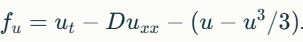

Then returns the mean squared residual as the loss, which penalizes deviations from the PDE at sampled points.


In [ ]:
def initial_condition_loss(model, x0, t0, u0):
    uv_pred = model(x0, t0)
    return ((uv_pred[:, 0:1] - u0) ** 2).mean()



---
This function computes the **initial condition loss** for the PINN model:

- It predicts the solution u at initial spatial points `x0` and initial time `t0` using the model.
- Compares the predicted `u` values (`uv_pred[:, 0:1]`) with the known initial condition values `u0`.
- Calculates the mean squared error between predicted and true initial values.
- This loss term ensures the model’s solution matches the given initial condition at `t = 0`during training.


---




In [ ]:
def boundary_condition_loss(model, xb, tb, ncase):
    xb = xb.clone().detach().float().requires_grad_(True)
    tb = tb.clone().detach().float()
    uv_pred = model(xb, tb)

    if ncase == 1:
        u_left = torch.tensor(analytical_solution(xmin, tb[:N_x].numpy()), dtype=torch.float32).reshape(-1, 1)
        u_right = torch.tensor(analytical_solution(xmax, tb[N_x:].numpy()), dtype=torch.float32).reshape(-1, 1)
        u_target = torch.cat([u_left, u_right], dim=0)
        return ((uv_pred[:, 0:1] - u_target) ** 2).mean()
    elif ncase == 2:
        left_vals = torch.ones_like(tb[:N_x])
        right_vals = torch.zeros_like(tb[N_x:])
        u_target = torch.cat([left_vals, right_vals]).reshape(-1, 1)
        return ((uv_pred[:, 0:1] - u_target) ** 2).mean()
    elif ncase == 3:
        u = uv_pred[:, 0:1]
        u_x = torch.autograd.grad(u, xb, torch.ones_like(u), create_graph=True)[0]
        u_x_left = u_x[:N_x]
        u_x_right = u_x[N_x:]
        tb_left_np = tb[:N_x].numpy()
        tb_right_np = tb[N_x:].numpy()
        ux_left_np = analytical_solution_derivative(xmin, tb_left_np, D, a)
        ux_right_np = analytical_solution_derivative(xmax, tb_right_np, D, a)
        ux_left = torch.tensor(ux_left_np, dtype=torch.float32).reshape(-1, 1)
        ux_right = torch.tensor(ux_right_np, dtype=torch.float32).reshape(-1, 1)
        return ((u_x_left - ux_left) ** 2).mean() + ((u_x_right - ux_right) ** 2).mean()
    elif ncase in (4, 5):
        u = uv_pred[:, 0:1]
        u_x = torch.autograd.grad(u, xb, torch.ones_like(u), create_graph=True)[0]
        return (u_x ** 2).mean()
    else:
        raise ValueError(f"Unsupported ncase {ncase}")



---
This function computes the **boundary condition loss** for the PINN model, enforcing different types of boundary conditions depending on `ncase`:

- It predicts the solution `u ` at boundary spatial points `xb` and times `tb`.It also handles the 5 cases explained before.


---




In [ ]:
def train_pinn_single_segment(t_start, t_end, ncase, epochs=4000):
    layers = [2, 100, 100, 100, 2]
    model = FHN_PINN(layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    x_tensor = torch.tensor(x_np, dtype=torch.float32).reshape(-1, 1)
    u0_np = analytical_solution(x_np, 0)
    u0 = torch.tensor(u0_np, dtype=torch.float32).reshape(-1, 1)
    t0 = torch.full_like(x_tensor, t_start)

    N_colloc = N_x * 10
    x_colloc = torch.tensor(np.random.uniform(xmin, xmax, N_colloc), dtype=torch.float32).reshape(-1, 1)
    t_colloc = torch.tensor(np.random.uniform(t_start, t_end, N_colloc), dtype=torch.float32).reshape(-1, 1)

    xb = torch.cat([
        torch.full((N_x, 1), xmin, dtype=torch.float32),
        torch.full((N_x, 1), xmax, dtype=torch.float32)
    ], dim=0)
    tb = torch.full((2 * N_x, 1), t_end, dtype=torch.float32)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = (
            100.0 * fhn_pde_loss(model, x_colloc, t_colloc, D, a) +
            30.0 * initial_condition_loss(model, x_tensor, t0, u0) +
            50.0 * boundary_condition_loss(model, xb, tb, ncase)
        )
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4e}")
    return model



---

This function trains a Physics-Informed Neural Network (PINN) to approximate the solution of a PDE on a time interval `[t_start, t_end]` with specified boundary conditions (`ncase`).

- It defines a fully connected neural network (`FHN_PINN`) with 3 hidden layers of 100 neurons each.
- Creates tensors for spatial points, initial conditions at `t_start`, and collocation points sampled randomly in space-time for enforcing the PDE.
- Defines boundary points at the spatial domain edges at time `t_end`.
- In each training epoch, it computes a weighted sum of three losses:
  - PDE residual loss at collocation points,
  - Initial condition loss at `t_start`,
  - Boundary condition loss at boundaries and `t_end`.
- They are weighted that way after trying to find the best balanced ratio to produce accurate results.  
- Uses Adam optimizer to minimize this composite loss.
- Prints loss every 500 epochs for a total of 4000 epochs.
- Returns the trained model after the specified number of epochs.



---



In [ ]:
# --- Run methods ---
u0 = ic_smooth()

start = time.time()
euler_u = euler_fdm_to_t(u0, n_steps, ncase)
euler_time = time.time() - start

start = time.time()
fvm_u = fvm_to_t(u0, n_steps, ncase)
fvm_time = time.time() - start

analytical_u = analytical_solution(x_np, t_eval)

print("Training PINN for t in [0, 0.5] ...")
start = time.time()
model = train_pinn_single_segment(0.0, t_eval, ncase, epochs=4000)
pinn_time = time.time() - start

x_tensor = torch.tensor(x_np, dtype=torch.float32).reshape(-1, 1)
t_tensor = torch.full_like(x_tensor, t_eval)
with torch.no_grad():
    pinn_u = model(x_tensor, t_tensor)[:, 0].numpy()

Training PINN for t in [0, 0.5] ...
Epoch 0: Loss = 7.8156e+01
Epoch 500: Loss = 2.9415e+00
Epoch 1000: Loss = 6.0526e-01
Epoch 1500: Loss = 3.8594e-01
Epoch 2000: Loss = 2.4195e-01
Epoch 2500: Loss = 1.8068e-01
Epoch 3000: Loss = 1.6057e-01
Epoch 3500: Loss = 1.4714e-01




---
This code snippet runs and compares three methods for solving a PDE at a given time `t_eval`:

- **Initial condition:** `u0` is set using a smooth analytical initial profile.
- **Euler method:** Solves the PDE using explicit Euler finite difference (`euler_fdm_to_t`), measuring execution time.
- **Finite volume method (FVM):** Solves the PDE with another numerical scheme (`fvm_to_t`), also timing it.
- **Analytical solution:** Computes the exact solution for comparison.
- **PINN training:** Trains the physics-informed neural network on the time interval `[0, t_eval]`, timing the training duration.
- **PINN prediction:** Uses the trained model to predict the solution at `t_eval`.


---



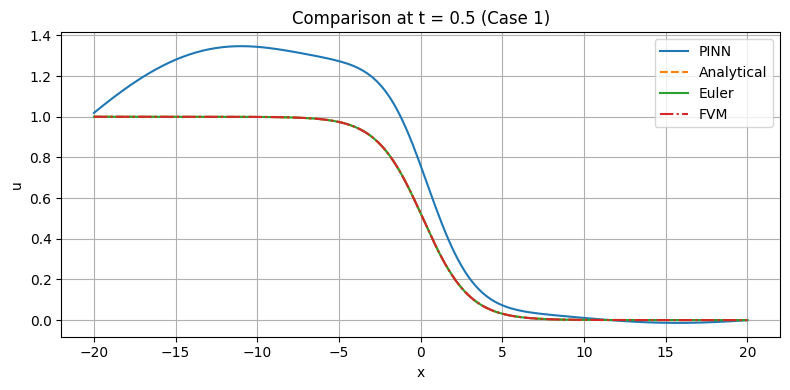

In [ ]:
# --- Plot u ---
plt.figure(figsize=(8, 4))
plt.plot(x_np, pinn_u, label="PINN")
plt.plot(x_np, analytical_u, label="Analytical", linestyle='--')
plt.plot(x_np, euler_u, label="Euler")
plt.plot(x_np, fvm_u, label="FVM", linestyle='-.')
plt.title(f"Comparison at t = {t_eval} (Case {ncase})")
plt.xlabel("x")
plt.ylabel("u")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()



---


This code snippet uses Matplotlib to plot and compare the solution profiles of the variable `u` at a specific time `t = t_{\text{eval}}` for all the methods.


---



In [ ]:
# --- Metrics ---
def classification_metrics(y_pred, y_true, threshold=0.5):
    y_pred_bin = (y_pred >= threshold).astype(int)
    y_true_bin = (y_true >= threshold).astype(int)
    TP = np.sum((y_pred_bin == 1) & (y_true_bin == 1))
    TN = np.sum((y_pred_bin == 0) & (y_true_bin == 0))
    FP = np.sum((y_pred_bin == 1) & (y_true_bin == 0))
    FN = np.sum((y_pred_bin == 0) & (y_true_bin == 1))
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else float('nan')
    return accuracy, precision

for label, ref in zip(['Euler', 'FVM', 'Analytical'], [euler_u, fvm_u, analytical_u]):
    rmse = np.sqrt(mean_squared_error(pinn_u, ref))
    mae = mean_absolute_error(pinn_u, ref)
    mse = mean_squared_error(pinn_u, ref)
    l2 = np.linalg.norm(pinn_u - ref) / np.linalg.norm(ref)
    acc, prec = classification_metrics(pinn_u, ref)

    print(f"\n{label} vs PINN:")
    print(f"RMSE       : {rmse:.4e}")
    print(f"MAE        : {mae:.4e}")
    print(f"MSE        : {mse:.4e}")
    print(f"L2 norm    : {l2:.4e}")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Precision  : {prec:.4f}")

print(f"\nEuler Time     : {euler_time:.8f} s")
print(f"FVM Time       : {fvm_time:.8f} s")
print(f"PINN Time      : {pinn_time:.2f} s")



Euler vs PINN:
RMSE       : 2.0699e-01
MAE        : 1.5661e-01
MSE        : 4.2844e-02
L2 norm    : 3.0246e-01
Accuracy   : 0.9750
Precision  : 0.9528

FVM vs PINN:
RMSE       : 2.0699e-01
MAE        : 1.5661e-01
MSE        : 4.2843e-02
L2 norm    : 3.0245e-01
Accuracy   : 0.9750
Precision  : 0.9528

Analytical vs PINN:
RMSE       : 2.0699e-01
MAE        : 1.5661e-01
MSE        : 4.2844e-02
L2 norm    : 3.0246e-01
Accuracy   : 0.9750
Precision  : 0.9528

Euler Time     : 0.02574778 s
FVM Time       : 0.02533221 s
PINN Time      : 271.09 s




---
This code evaluates and compares the accuracy and efficiency of different PDE solution methods (PINN, Euler, FVM, Analytical) using several metrics:

- **Classification metrics** (accuracy and precision) convert continuous predictions into binary form based on a threshold to assess agreement in a classification sense having values from 0 to 1.
- **Regression metrics** such as RMSE, MAE, MSE, and relative L2 norm quantify the numerical difference between PINN predictions and reference solutions.
- The metrics are computed pairwise between PINN and each reference method.
- The code also prints the computational time taken by each method.


---







---



**Results for Case 4:**


---
done by changing the predefined `ncase` variable from 1 to 4.


Training PINN for t in [0, 0.5] ...
Epoch 0: Loss = 1.7263e+01
Epoch 500: Loss = 1.1441e+00
Epoch 1000: Loss = 2.8375e-01
Epoch 1500: Loss = 8.5379e-02
Epoch 2000: Loss = 1.4904e-02
Epoch 2500: Loss = 6.2264e-03
Epoch 3000: Loss = 3.9278e-03
Epoch 3500: Loss = 2.6772e-03


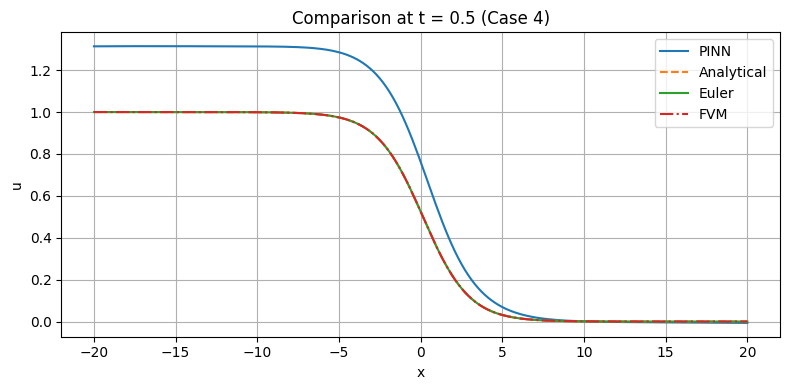


Euler vs PINN:
RMSE       : 2.2325e-01
MAE        : 1.7175e-01
MSE        : 4.9839e-02
L2 norm    : 3.2621e-01
Accuracy   : 0.9750
Precision  : 0.9528

FVM vs PINN:
RMSE       : 2.2324e-01
MAE        : 1.7175e-01
MSE        : 4.9838e-02
L2 norm    : 3.2621e-01
Accuracy   : 0.9750
Precision  : 0.9528

Analytical vs PINN:
RMSE       : 2.2325e-01
MAE        : 1.7175e-01
MSE        : 4.9839e-02
L2 norm    : 3.2621e-01
Accuracy   : 0.9750
Precision  : 0.9528

Euler Time     : 0.00544119 s
FVM Time       : 0.00594306 s
PINN Time      : 289.67 s


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---------- global parameters ----------
D, a = 1.0, 0.3
xmin, xmax = -20, 20
N_x = 200
dt = 0.002
x_np = np.linspace(xmin, xmax, N_x)
dx = x_np[1] - x_np[0]
ncase = 4 # Change between 1 to 5
t_eval = 0.5
n_steps = int(t_eval / dt)

# ---------- Safe exp ----------
def safe_exp(z):
    return np.exp(np.clip(z, -700, 700))

# ---------- Analytical ----------
def analytical_solution(x, t, D=1.0, a=0.3):
    return 1 / (1 + np.exp(x / np.sqrt(2 * D) + (a - 0.5) * t))

def analytical_solution_derivative(x, t, D=1.0, a=0.3):
    exp_term = safe_exp(x / np.sqrt(2 * D) + (a - 0.5) * t)
    denom = (1 + exp_term) ** 2
    return -exp_term / (np.sqrt(2 * D) * denom)

# ---------- Initial & Boundary Conditions ----------
def ic_smooth():
    return analytical_solution(x_np, 0).flatten()

def apply_bc(u, t, ncase):
    if ncase == 1:
        u[0], u[-1] = analytical_solution(x_np[0], t), analytical_solution(x_np[-1], t)
    elif ncase == 2:
        u[0], u[-1] = 1.0, 0.0
    elif ncase == 3:
        arg0 = x_np[0] / np.sqrt(2 * D) + (a - 0.5) * t
        ux0 = -safe_exp(arg0) / (np.sqrt(2 * D) * (1 + safe_exp(arg0)) ** 2)
        argn = x_np[-1] / np.sqrt(2 * D) + (a - 0.5) * t
        uxn = -safe_exp(argn) / (np.sqrt(2 * D) * (1 + safe_exp(argn)) ** 2)
        u[0] = u[1] - dx * ux0
        u[-1] = u[-2] + dx * uxn
    elif ncase == 4:
        u[0], u[-1] = u[1], u[-2]
    elif ncase == 5:
        u[0], u[-1] = u[0], u[-1]
    return u

# ---------- Euler Method ----------
def euler_fdm_to_t(u0, n_steps, ncase):
    u = u0.copy()
    for n in range(n_steps):
        rhs = D * (u[2:] - 2 * u[1:-1] + u[:-2]) / dx ** 2 - u[1:-1] * (1 - u[1:-1]) * (a - u[1:-1])
        u[1:-1] += dt * rhs
        u = apply_bc(u, (n + 1) * dt, ncase)
    return u

# ---------- Finite Volume Method ----------
def fvm_to_t(u0, n_steps, ncase):
    u = u0.copy()
    for n in range(n_steps):
        flux = np.zeros_like(u)
        flux[1:-1] = D * (u[2:] - u[:-2]) / (2 * dx)
        div_flux = np.zeros_like(u)
        div_flux[1:-1] = (flux[2:] - flux[:-2]) / (2 * dx)
        reaction = u * (1 - u) * (a - u)
        u[1:-1] += dt * (div_flux[1:-1] - reaction[1:-1])
        u = apply_bc(u, (n + 1) * dt, ncase)
    return u

# ---------- PINN Model ----------
class FHN_PINN(nn.Module):
    def __init__(self, layers):
        super(FHN_PINN, self).__init__()
        modules = []
        for i in range(len(layers) - 1):
            modules.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                modules.append(nn.Tanh())
        self.net = nn.Sequential(*modules)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

def fhn_pde_loss(model, x, t, D, a):
    x = x.clone().detach().float().requires_grad_(True)
    t = t.clone().detach().float().requires_grad_(True)
    uv = model(x, t)
    u = uv[:, 0:1]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), create_graph=True)[0]
    f_u = u_t - D * u_xx - (u - u ** 3 / 3)
    return (f_u ** 2).mean()

def initial_condition_loss(model, x0, t0, u0):
    uv_pred = model(x0, t0)
    return ((uv_pred[:, 0:1] - u0) ** 2).mean()

def boundary_condition_loss(model, xb, tb, ncase):
    xb = xb.clone().detach().float().requires_grad_(True)
    tb = tb.clone().detach().float()
    uv_pred = model(xb, tb)

    if ncase == 1:
        u_left = torch.tensor(analytical_solution(xmin, tb[:N_x].numpy()), dtype=torch.float32).reshape(-1, 1)
        u_right = torch.tensor(analytical_solution(xmax, tb[N_x:].numpy()), dtype=torch.float32).reshape(-1, 1)
        u_target = torch.cat([u_left, u_right], dim=0)
        return ((uv_pred[:, 0:1] - u_target) ** 2).mean()
    elif ncase == 2:
        left_vals = torch.ones_like(tb[:N_x])
        right_vals = torch.zeros_like(tb[N_x:])
        u_target = torch.cat([left_vals, right_vals]).reshape(-1, 1)
        return ((uv_pred[:, 0:1] - u_target) ** 2).mean()
    elif ncase == 3:
        u = uv_pred[:, 0:1]
        u_x = torch.autograd.grad(u, xb, torch.ones_like(u), create_graph=True)[0]
        u_x_left = u_x[:N_x]
        u_x_right = u_x[N_x:]
        tb_left_np = tb[:N_x].numpy()
        tb_right_np = tb[N_x:].numpy()
        ux_left_np = analytical_solution_derivative(xmin, tb_left_np, D, a)
        ux_right_np = analytical_solution_derivative(xmax, tb_right_np, D, a)
        ux_left = torch.tensor(ux_left_np, dtype=torch.float32).reshape(-1, 1)
        ux_right = torch.tensor(ux_right_np, dtype=torch.float32).reshape(-1, 1)
        return ((u_x_left - ux_left) ** 2).mean() + ((u_x_right - ux_right) ** 2).mean()
    elif ncase in (4, 5):
        u = uv_pred[:, 0:1]
        u_x = torch.autograd.grad(u, xb, torch.ones_like(u), create_graph=True)[0]
        return (u_x ** 2).mean()
    else:
        raise ValueError(f"Unsupported ncase {ncase}")

def train_pinn_single_segment(t_start, t_end, ncase, epochs=4000):
    layers = [2, 100, 100, 100, 2]
    model = FHN_PINN(layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    x_tensor = torch.tensor(x_np, dtype=torch.float32).reshape(-1, 1)
    u0_np = analytical_solution(x_np, 0)
    u0 = torch.tensor(u0_np, dtype=torch.float32).reshape(-1, 1)
    t0 = torch.full_like(x_tensor, t_start)

    N_colloc = N_x * 10
    x_colloc = torch.tensor(np.random.uniform(xmin, xmax, N_colloc), dtype=torch.float32).reshape(-1, 1)
    t_colloc = torch.tensor(np.random.uniform(t_start, t_end, N_colloc), dtype=torch.float32).reshape(-1, 1)

    xb = torch.cat([
        torch.full((N_x, 1), xmin, dtype=torch.float32),
        torch.full((N_x, 1), xmax, dtype=torch.float32)
    ], dim=0)
    tb = torch.full((2 * N_x, 1), t_end, dtype=torch.float32)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = (
            100.0 * fhn_pde_loss(model, x_colloc, t_colloc, D, a) +
            30.0 * initial_condition_loss(model, x_tensor, t0, u0) +
            50.0 * boundary_condition_loss(model, xb, tb, ncase)
        )
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4e}")
    return model

# --- Run methods ---
u0 = ic_smooth()

start = time.time()
euler_u = euler_fdm_to_t(u0, n_steps, ncase)
euler_time = time.time() - start

start = time.time()
fvm_u = fvm_to_t(u0, n_steps, ncase)
fvm_time = time.time() - start

analytical_u = analytical_solution(x_np, t_eval)

print("Training PINN for t in [0, 0.5] ...")
start = time.time()
model = train_pinn_single_segment(0.0, t_eval, ncase, epochs=4000)
pinn_time = time.time() - start

x_tensor = torch.tensor(x_np, dtype=torch.float32).reshape(-1, 1)
t_tensor = torch.full_like(x_tensor, t_eval)
with torch.no_grad():
    pinn_u = model(x_tensor, t_tensor)[:, 0].numpy()

# --- Plot u ---
plt.figure(figsize=(8, 4))
plt.plot(x_np, pinn_u, label="PINN")
plt.plot(x_np, analytical_u, label="Analytical", linestyle='--')
plt.plot(x_np, euler_u, label="Euler")
plt.plot(x_np, fvm_u, label="FVM", linestyle='-.')
plt.title(f"Comparison at t = {t_eval} (Case {ncase})")
plt.xlabel("x")
plt.ylabel("u")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# --- Metrics ---
def classification_metrics(y_pred, y_true, threshold=0.5):
    y_pred_bin = (y_pred >= threshold).astype(int)
    y_true_bin = (y_true >= threshold).astype(int)
    TP = np.sum((y_pred_bin == 1) & (y_true_bin == 1))
    TN = np.sum((y_pred_bin == 0) & (y_true_bin == 0))
    FP = np.sum((y_pred_bin == 1) & (y_true_bin == 0))
    FN = np.sum((y_pred_bin == 0) & (y_true_bin == 1))
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else float('nan')
    return accuracy, precision

for label, ref in zip(['Euler', 'FVM', 'Analytical'], [euler_u, fvm_u, analytical_u]):
    rmse = np.sqrt(mean_squared_error(pinn_u, ref))
    mae = mean_absolute_error(pinn_u, ref)
    mse = mean_squared_error(pinn_u, ref)
    l2 = np.linalg.norm(pinn_u - ref) / np.linalg.norm(ref)
    acc, prec = classification_metrics(pinn_u, ref)

    print(f"\n{label} vs PINN:")
    print(f"RMSE       : {rmse:.4e}")
    print(f"MAE        : {mae:.4e}")
    print(f"MSE        : {mse:.4e}")
    print(f"L2 norm    : {l2:.4e}")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Precision  : {prec:.4f}")

print(f"\nEuler Time     : {euler_time:.8f} s")
print(f"FVM Time       : {fvm_time:.8f} s")
print(f"PINN Time      : {pinn_time:.2f} s")
